In [1]:
import os 
import torch 
import numpy as np 
import pandas as pd

from math import ceil
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# from mmpfn.models.tabpfn_v2 import TabPFNClassifier
from mmpfn.models.tabpfn_v2 import TabPFNClassifier
from mmpfn.models.tabpfn_v2.constants import ModelInterfaceConfig
from mmpfn.models.tabpfn_v2.preprocessing import PreprocessorConfig
from mmpfn.scripts_finetune.finetune_tabpfn_main import fine_tune_tabpfn

In [2]:
col_features = [
"Age", "Breed1", "Breed2", "Color1", 'Color2', 'Color3', 'Dewormed', 'Fee', 'FurLength', 'Gender', 'Health', 'MaturitySize', 'PhotoAmt', 'State', 'Sterilized', 'Type', 'Vaccinated', 'VideoAmt', 'Quantity'
]
col_exclude = [
'PetID', 'RescureID', 'Description', 'Name'
]
col_target = 'AdoptionSpeed'

cat_features = [
"Breed1", "Breed2", "Color1", 'Color2', 'Color3', 'Dewormed', 'FurLength', 'Gender', 'Health', 'MaturitySize', 'State', 'Sterilized', 'Type', 'Vaccinated'
]
cat_features_index = [col_features.index(feature) for feature in cat_features]

train = pd.read_csv("datasets/petfinder-adoption-prediction/train/train.csv")
datasets_dir = "datasets/petfinder-adoption-prediction"

train["PetID"] = train["PetID"].astype(str)
train_images = [
    f
    for f in os.listdir(os.path.join(datasets_dir, "train_images"))
    if f.endswith(".jpg")
]
train_images = [f for f in train_images if f.split("-")[0] in train["PetID"].values]
train_images_df = pd.DataFrame(
    {
        "PetID": [f.split("-")[0] for f in train_images],
        "ImageNumber": [f.split("-")[1].split(".")[0] for f in train_images],
    }
)
train_images_df = train_images_df[train_images_df["ImageNumber"] == "1"]
train = train.merge(train_images_df, on="PetID", how="left")
train = train[train["ImageNumber"].notna()]
train["ImagePath"] = train["PetID"] + "-1.jpg"

X_train, X_test, y_train, y_test = train_test_split(train[col_features], train[col_target], test_size=0.2)

for col, any_na in X_train.isna().any().items():
  if any_na:
    X_train[col] = X_train[col].fillna(0)

X_train_ = torch.tensor(X_train.to_numpy())
y_train_ = torch.tensor(y_train.to_numpy())

X_test_ = torch.tensor(X_test.to_numpy())
y_test_ = torch.tensor(y_test.to_numpy())

In [3]:
save_path_to_fine_tuned_model = "./finetuned_mmpfn_adoption_tabular.ckpt"

Fine-tuning Steps: 31it [13:44, 27.50s/it, Best Val. Loss=1.33, Best Val. Score=-1.33, Training Loss=1.32, Val. Loss=1.33, Patience=20, Utilization=0, Grad Norm=0.683]                        
[2025-07-30 22:44:51,499] INFO - === Fine-Tuning Report for TabPFN ===
        	Total Time Spent: 830.2851181030273
        	Initial Validation Loss: 	 1.3548868722161214
        	Best Validation Loss: 	 1.3291017421177413
        	Total Steps: 31
        	Best Step: 25
        	Avg. Time per Step: 26.783391260331676
        	Avg. Device Utilization: 0.0
        


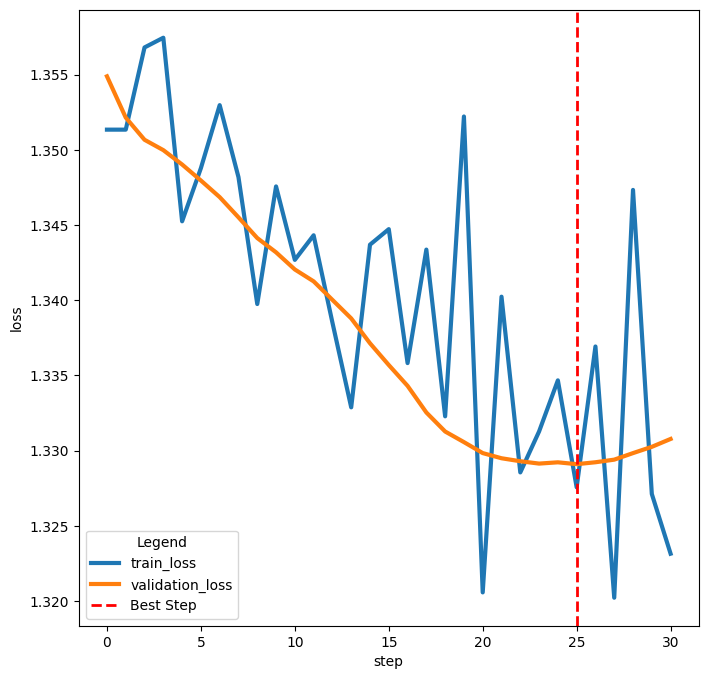

In [4]:
fine_tune_tabpfn(
    path_to_base_model="auto",
    save_path_to_fine_tuned_model=save_path_to_fine_tuned_model,
    # Finetuning HPs
    time_limit=60,
    finetuning_config={"learning_rate": 0.00001, "batch_size": 4, "max_steps": 30},
    validation_metric="log_loss",
    # Input Data
    X_train=X_train,
    y_train=y_train,
    categorical_features_index=None,
    device="cuda",  # use "cpu" if you don't have a GPU
    task_type="multiclass",
    # Optional
    show_training_curve=True,  # Shows a final report after finetuning.
    logger_level=0,  # Shows all logs, higher values shows less
)

In [6]:
# disables preprocessing at inference time to match fine-tuning
no_preprocessing_inference_config = ModelInterfaceConfig(
    FINGERPRINT_FEATURE=False,
    PREPROCESS_TRANSFORMS=[PreprocessorConfig(name='none')]
)

# Evaluate on Test Data
model_finetuned = TabPFNClassifier(
    model_path=save_path_to_fine_tuned_model,
    inference_config=no_preprocessing_inference_config,
    ignore_pretraining_limits=True,
)
clf_finetuned = model_finetuned.fit(X_train, y_train)

/home/wall/works/research/MultiModalPFN/mmpfn/models/tabpfn_v2/classifier.py:414: UserWarning: Number of samples 11721 is greater than the maximum Number of samples 10000 supported by the model. You may see degraded performance.
  X, y, feature_names_in, n_features_in = validate_Xy_fit(


In [8]:
sum(p.numel() for p in model_finetuned.model_.parameters() if p.requires_grad)

7244554

In [7]:
print("accuracy_score (Finetuned):", accuracy_score(y_test, clf_finetuned.predict(X_test)))

accuracy_score (Finetuned): 0.41760491299897645
